In [1]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:

!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric


Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 319, in run
    reqs, check_supported_wheels=not options.target_dir
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 128, in resolve
    requirements, max_rounds=try_to_avoid_resolution_too_deep
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 473, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line

In [ ]:
!nvidia-smi

Wed Feb 24 19:23:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    31W /  70W |   2010MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from torch.autograd import Variable
import torch_geometric.transforms
from torch_geometric.transforms import knn_graph
import torch_geometric.data
from torch_geometric.data import Data
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import torch
import pyarrow as pa
import pyarrow.parquet as pq
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch_geometric.nn import knn_graph
import os 
from itertools import cycle,islice
from torch.utils.data import *
from functools import partial
import timeit

ModuleNotFoundError: ignored

In [ ]:

import argparse
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
parser = argparse.ArgumentParser()
#parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=50, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=64, help='Initial learning rate.') #100
parser.add_argument('--maxnodes', type=int, default=1000, help='max nodes.') #100
parser.add_argument('--lr', type=float, default=0.001, help='Initial learning rate.') #0.001
parser.add_argument('--dropout', type=float, default=0.3, help='Dropout rate (1 - keep probability).')
args = parser.parse_args([])
torch.backends.cudnn.benchmark = True

In [ ]:
class ParquetDataset(Dataset):
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        self.cols = None 
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['X_jets'] = np.float32(data['X_jets'][0]) 
        # Preprocessing
        data['X_jets'] = data['X_jets'][0:]
        data['X_jets'][data['X_jets'] < 1.e-3] = 0. # Zero-Suppression
        return dict(data)
    def __len__(self):
        return self.parquet.num_row_groups

In [ ]:
def get_data_loader(datasets, batch_size, cut, random_sampler=True):
    dset = ConcatDataset([ParquetDataset(dataset) for dataset in datasets])
    idxs = np.random.permutation(len(dset))
    if random_sampler: 
        random_sampler = sampler.SubsetRandomSampler(idxs[:cut])
    else: 
        random_sampler = None
    data_loader = DataLoader(dataset=dset, batch_size=batch_size, shuffle=False, num_workers=10, sampler=random_sampler, pin_memory=True)
    return data_loader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/My\ Drive/3 channels

/content/drive/My Drive/3 channels


In [ ]:
datasets = ['../v22/parquets/Boosted_Jets_Sample-%i.snappy.parquet'%i for i in range(1)]
data_loader = get_data_loader(datasets, args.batch_size, cut = None, random_sampler = True)

In [ ]:
valsets = ['../v22/parquets/Boosted_Jets_Sample-%i.snappy.parquet'%i for i in range(2,3)]
VaLoader = get_data_loader(valsets, args.batch_size, cut = None, random_sampler = True)

In [ ]:
import matplotlib.pyplot as plt
"""
plt.hist(np.array(np.log(ener)*(-1)+10)/10, bins = 10)
plt.show()
"""

'\nplt.hist(np.array(np.log(ener)*(-1)+10)/10, bins = 10)\nplt.show()\n'

In [ ]:
def shapeHcal(hcal):
  check=np.unique(hcal.cpu().numpy())
  check=check[check!=0].tolist()
  cenX,cenY=[],[]
  for hit in check:
      x,y=np.where(hcal.cpu().numpy()==hit)
      centerX=x[12]
      centerY=y[2]
      cenX.append(centerX)
      cenY.append(centerY)
  return torch.from_numpy(np.array(cenX)),torch.from_numpy(np.array(cenY))

In [ ]:
import torch_geometric.transforms
from torch_geometric.nn import knn_graph
import torch_geometric.data
import torch 
from torch_geometric.data import Data
import numpy as np
def torchjets(datei,number1,number2):

    cols = None

    graphs=[]

    for i in range(number1,number2):

      tracker=datei[i][0]
      ecal=datei[i][1]
      hcal=datei[i][2]

      xhitT,yhitT=torch.nonzero(tracker,as_tuple=True)  ## Select hits in detector
      eneT=tracker[xhitT,yhitT]*50## Select energies of hits
      featsTr=torch.stack((xhitT.float(),yhitT.float(),eneT),dim=1).cuda() ## concatenate x,y locations and energies (3 features in total)

      xhit2,yhit2=torch.nonzero(ecal,as_tuple=True)  ## Select hits in detector
      eneEcal=ecal[xhit2,yhit2]*50## Select energies of hits
      feats=torch.stack((xhit2.float(),yhit2.float(),eneEcal),dim=1).cuda() ## concatenate x,y locations and energies (3 features in total)

      xhitH,yhitH=shapeHcal(hcal)#torch.nonzero(hcal,as_tuple=True)  ## Select hits in detector
      eneHcal=hcal[xhitH.long(),yhitH.long()]*50## Select energies of hits
      featsH=torch.stack((xhitH.float().cuda(),yhitH.float().cuda(),eneHcal.cuda()),dim=1).cuda() ## concatenate x,y locations and energies (3 features in total)

      tFeat=featsTr.shape[0]
      zeros=feats.shape[0]
      ones=featsH.shape[0]
      #fillit=args.maxnodes -(zeros+ones)
      #rems=torch.zeros((fillit,3)).cuda()

      both=torch.cat((featsTr,feats,featsH)).cuda()
      #both=torch.cat((both,rems))

      cords=both[:,[0,1]].cuda() ## cords = x,y coordinates 

      edge_index = knn_graph(cords[:args.maxnodes], k=6, batch=None, loop=True)  ## Create knn graph adjacency matrix 
      #edge_index2 = knn_graph(cords[ones:args.maxnodes], k=4, batch=None, loop=True)  ## Create knn graph adjacency matrix 
      #edge_index2=edge_index2#+zeros
      #combEdge=torch.cat((edge_index,edge_index2),dim=1).cuda()

      layers=torch.cat((torch.ones(tFeat)*3,torch.ones(zeros)*5.5,torch.ones(ones)*8.5)).cuda()
      donnees=Data(x=both[:args.maxnodes],edge_index=edge_index,layers=layers[:args.maxnodes]) ## Create graph data with feature matrix x and adjacency matrix edge_index
      
      graphs.append(donnees)

    return graphs

In [ ]:
import VAE_version2

In [ ]:
model3=VAE_version2.GraphAE(4,16,32,64,64,64,64, args.maxnodes)#DiffAE.GraphAE()
#model3.train()
#model3.to(device)

In [ ]:
#pytorch_total_params = sum(p.numel() for p in model3.parameters())
#print(pytorch_total_params)

In [ ]:
optimizer = torch.optim.Adam(model3.parameters(), lr=args.lr)
#optimizer = torch.optim.SGD(model3.parameters(), lr=args.lr, momentum=0.9)

In [ ]:

checkpoint = torch.load('./gvae_3chan_2021_2.pth')
model3.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
model3.eval()
model3.to(device)


GraphAE(
  (sage1): DenseSAGEConv(4, 16)
  (sage3): DenseSAGEConv(16, 64)
  (sage5): DenseSAGEConv(64, 64)
  (sage6): DenseSAGEConv(64, 64)
  (poolit1): Linear(in_features=16, out_features=250, bias=True)
  (poolit2): Linear(in_features=64, out_features=50, bias=True)
  (tr2): Linear(in_features=64, out_features=16, bias=True)
  (rev2): Linear(in_features=16, out_features=64, bias=True)
  (revsage1): DenseSAGEConv(16, 4)
  (revsage3): DenseSAGEConv(64, 16)
  (revsage5): DenseSAGEConv(64, 64)
  (revsage6): DenseSAGEConv(64, 64)
  (drop5): Dropout(p=0.5, inplace=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (bano1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bano2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bano3): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bano4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
## generate list to count nodes for each graph
def nodeCounter(samples):
    inds=[]
    for k in samples:
        inds.append(k['x'].shape[0])
    return inds

In [ ]:
def ref(bsize,nodeC,i1,i2):
  maxC=np.max(np.array(nodeC))
  maxC=args.maxnodes#maxC + (4 - maxC % 4) ##max num of nodes 1161%4
  refMat=np.zeros((bsize,maxC)) ## matrix of zeros
  for pi in range(i1,i2):##10
    refMat[pi,:nodeC[pi]]=1 ## fill ones 
  return refMat,maxC

In [ ]:
def assigner(nodelist):
  fin=[]
  countit=0
  for m in nodelist:
      fin.append(np.repeat(countit,m))
      countit+=1
  return np.array(fin)

In [ ]:
from optimizer import loss_function

In [ ]:
import time
from torch_geometric.utils import to_dense_batch, to_dense_adj
for epoch in range(20):
  count=0
  c1,c2=0,args.batch_size
  epLoss=0
  #t = time.time()
  data_loader = get_data_loader(datasets, args.batch_size, cut = None, random_sampler = True)
  for i, data in enumerate(data_loader):
        ecal2 = data['X_jets'].cuda()
        rawGraph=torchjets(ecal2,0,args.batch_size) ##Generating graphs from raw data 
        nodeCount=nodeCounter(rawGraph)
        lengs=torch.LongTensor(np.hstack(assigner(np.array(nodeCount[c1:c2])))).cuda()
        
        compress=torch_geometric.data.Batch.from_data_list(rawGraph)

        gra=compress.x.clone().cuda()
        adj=compress.edge_index.clone().cuda()
        detector=compress.layers.clone().cuda()

        gra2=torch.cat((gra,detector.unsqueeze_(1)),dim=1)
        
        count+=1    
        
        whole,mask=to_dense_batch(gra2, lengs, fill_value=0, max_num_nodes=args.maxnodes)
        wholeAdj=to_dense_adj(adj, lengs, edge_attr=None, max_num_nodes=args.maxnodes).cuda()

        whole=whole.cuda()
        mask=mask.cuda()
        lengs=lengs.cuda()
        
        optimizer.zero_grad()
        t = time.time()
        r1 ,adj1,mu,sig,m_loss,o_loss= model3(whole,wholeAdj,lengs,mask,args.maxnodes)
        #print("time=", "{:.5f}".format(time.time() - t))
        loss = loss_function(r1,whole,nodeCount,lengs,args.maxnodes,mu,sig)/args.batch_size+m_loss+o_loss

        loss.backward()

        optimizer.step()

        #model3.zero_grad()

        cur_loss = loss.item()
        
        epLoss+=float(cur_loss)

        if count%230==0:
            print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(epLoss/count),"time=", "{:.5f}".format(time.time() - t))
            t = time.time()

            with torch.no_grad():
              model3.eval()
              VaLoss=0
              countVal=0
              c3,c4=0,args.batch_size
              VaLoader= get_data_loader(valsets, args.batch_size, cut = None, random_sampler = True)
              for data2 in islice(VaLoader,0,20):
                ecal3 = data2['X_jets'].cuda()
                rawGraph3=torchjets(ecal3,0,args.batch_size) ##Generating graphs from raw data 
                nodeCount3=nodeCounter(rawGraph3)
                lengs3=torch.LongTensor(np.hstack(assigner(np.array(nodeCount3[c3:c4])))).cuda()
                
                compress3=torch_geometric.data.Batch.from_data_list(rawGraph3)

                gra3=compress3.x
                adj3=compress3.edge_index
                detector3=compress3.layers.clone().cuda()

                gra23=torch.cat((gra3,detector3.unsqueeze_(1)),dim=1)

                countVal+=1

                whole3,mask3=to_dense_batch(gra23, lengs3, fill_value=0, max_num_nodes=args.maxnodes)
                wholeAdj3=to_dense_adj(adj3, lengs3, edge_attr=None, max_num_nodes=args.maxnodes).cuda()

                whole3=whole3.cuda()
                mask3=mask3.cuda()
                lengs3=lengs3.cuda()

                r13 ,adj13,mu3,sig3,m_loss3,o_loss3= model3(whole3,wholeAdj3,lengs3,mask3,args.maxnodes)
                loss3 = loss_function(r13,whole3,nodeCount,lengs3,args.maxnodes,mu3,sig3)/args.batch_size+m_loss3+o_loss3
                cur_loss3 = loss3.item()
                VaLoss+=float(cur_loss3)

              print("val_loss=", "{:.5f}".format(VaLoss/countVal))

  torch.save({
        'epoch': epoch,
        'model_state_dict': model3.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch':epoch,
        'loss': loss,
        'epLoss':epLoss
        }, './gvae_3chan_2021_2.pth')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0001 train_loss= 24.97992 time= 0.12414
val_loss= 95.81678
Epoch: 0001 train_loss= 19.02729 time= 0.12757
val_loss= 3.21819
Epoch: 0002 train_loss= 2.43071 time= 0.12322
val_loss= 1.71919
Epoch: 0002 train_loss= 2.01346 time= 0.12320
val_loss= 1.66509
Epoch: 0003 train_loss= 1.40297 time= 0.14486
val_loss= 1.39908
Epoch: 0003 train_loss= 1.34510 time= 0.14331
val_loss= 1.35530
Epoch: 0004 train_loss= 1.24159 time= 0.13813
val_loss= 1.27302
Epoch: 0004 train_loss= 1.21136 time= 0.14066
val_loss= 1.14263
Epoch: 0005 train_loss= 1.14755 time= 0.13506
val_loss= 1.38440
Epoch: 0005 train_loss= 1.14367 time= 0.14039
val_loss= 1.25159
Epoch: 0006 train_loss= 1.08801 time= 0.13500
val_loss= 1.05899
Epoch: 0006 train_loss= 1.07943 time= 0.13133
val_loss= 1.03845
Epoch: 0007 train_loss= 1.03765 time= 0.13184
val_loss= 1.01455
Epoch: 0007 train_loss= 1.03800 time= 0.13273
val_loss= 1.00090
Epoch: 0008 train_loss= 0.98171 time= 0.13639
val_loss= 0.98378
Epoch: 0008 train_loss= 0.99318 time=

In [ ]:
detector.shape

torch.Size([56028, 1])

In [ ]:
xhitT,yhitT=torch.nonzero(ecal2[0][0],as_tuple=True)

In [ ]:
xhitT

tensor([ 7, 10, 11, 19, 36, 40, 46, 47, 50, 52, 55, 59, 60, 61, 62, 62, 63, 65,
        65, 65], device='cuda:0')

In [ ]:
gra.shape

In [ ]:
35941*3

In [ ]:
testsets = ['../v22/parquets/Boosted_Jets_Sample-%i.snappy.parquet'%i for i in range(3,4)]
testloader = get_data_loader(testsets, args.batch_size, cut = None, random_sampler = True)

In [ ]:
import time
import time
from torch_geometric.utils import to_dense_batch, to_dense_adj
for epoch in range(1):
      #model.train()
  count=0
  c5,c6=0,args.batch_size
  epLoss=0
  #t = time.time()

  recs=[]
  orig=[]
  maskit=[]

  with torch.no_grad():
    model3.eval()
    for k, data4 in enumerate(testloader):
          ecal4 = data4['X_jets'].cuda()
          rawGraph4=torchjets(ecal4,0,args.batch_size) ##Generating graphs from raw data 
          nodeCount4=nodeCounter(rawGraph4)
          lengs4=torch.LongTensor(np.hstack(assigner(np.array(nodeCount4[c5:c6])))).cuda()
          
          compress4=torch_geometric.data.Batch.from_data_list(rawGraph4)

          gra4=compress4.x
          adj4=compress4.edge_index
          detector4=compress4.layers.clone().cuda()

          gra24=torch.cat((gra4,detector4.unsqueeze_(1)),dim=1)
        

          whole4,mask4=to_dense_batch(gra24, lengs4, fill_value=0, max_num_nodes=args.maxnodes)#refMat.shape[1])
          wholeAdj4=to_dense_adj(adj4, lengs4, edge_attr=None, max_num_nodes=args.maxnodes).cuda()#refMat.shape[1]).cuda()

          count+=1
      
          whole4=whole4.cuda()
          mask4=mask4.cuda()
          t = time.time()
          r14 ,adj4,mu4,sig4,mc_loss4,o_loss4= model3(whole4,wholeAdj4,lengs4,mask4,args.maxnodes)
          print("time=", "{:.5f}".format(time.time() - t))

          loss4 = loss_function(r14,whole4,nodeCount4,lengs4,args.maxnodes,mu4,sig4)/args.batch_size+mc_loss4+o_loss4
          #loss3 = loss_function(r13,whole3,nodeCount,lengs3,args.maxnodes,mu3,sig3)/args.batch_size+m_loss3+o_loss3
          cur_loss4 = loss4.item()
          recs+=r14
          orig+=whole4
          maskit+=mask4
          if count==20:
            
            
            break;
          



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time= 0.13963
time= 0.10066
time= 0.10703
time= 0.10153
time= 0.09400
time= 0.07707
time= 0.07929
time= 0.07986
time= 0.06739
time= 0.08147
time= 0.06204
time= 0.05525
time= 0.05763
time= 0.05109
time= 0.05957
time= 0.06421
time= 0.07438
time= 0.07413
time= 0.07059
time= 0.07532


In [ ]:
baseline.shape

torch.Size([64, 1000, 4])

In [ ]:
baseline=torch.stack(recs)

In [ ]:
baseOrigs=torch.stack(orig)

In [ ]:
baseMasks=torch.stack(maskit)

In [ ]:
copyrecs=torch.zeros((baseline.shape[0],baseline.shape[1],baseline.shape[2]))
copyrecs[:,:,0]=baseline[:,:,2].clone()
copyrecs[:,:,1]=baseline[:,:,0].clone()
copyrecs[:,:,2]=baseline[:,:,1].clone()
copyrecs[:,:,3]=baseline[:,:,3].clone()

In [ ]:
copyorigs=torch.zeros((baseOrigs.shape[0],baseOrigs.shape[1],baseOrigs.shape[2]))
copyorigs[:,:,0]=baseOrigs[:,:,2].clone()
copyorigs[:,:,1]=baseOrigs[:,:,0].clone()
copyorigs[:,:,2]=baseOrigs[:,:,1].clone()
copyorigs[:,:,3]=baseOrigs[:,:,3].clone()

In [ ]:
!pip install energyflow
!pip install numpy cython
!pip install POT

In [ ]:
import energyflow
import ot

In [ ]:
emd_res=[]
for samp in range(3800):
  hcals2=hcalChan(baseOrigs,samp)
  ecals2=EcalChan(baseOrigs,samp)
  emd_res.append(energyflow.emd.emd(baseline[samp][ecals2[0]:hcals2[0],0].cpu().numpy(), baseOrigs[samp][ecals2[0]:hcals2[0],:].cpu().numpy(), R=1.0, norm=False, beta=1.0, measure='euclidean', coords='hadronic', 
                    return_flow=False, gdim=None, mask=False, n_iter_max=100000, periodic_phi=False, phi_col=2, empty_policy='error'))

In [ ]:
copyorigs.shape

torch.Size([1280, 1000, 4])

In [ ]:
emd_res2=[]
for samp in range(3800):
  hcals2=hcalChan(copyorigs,samp)
  ecals2=EcalChan(copyorigs,samp)
  if len(hcals2)>4:
    copyrecs[samp][ecals2[0]:hcals2[0]:,0]*=0.1
    copyorigs[samp][ecals2[0]:hcals2[0]:,0]*=0.1
    emd_res2.append(energyflow.emd.emd(copyrecs[samp][ecals2[0]:hcals2[0]:,0].cpu().numpy(), copyorigs[samp][ecals2[0]:hcals2[0]:,0].cpu().numpy(), R=1.0, norm=False, beta=1.0, measure='euclidean', coords='hadronic', 
                      return_flow=False, gdim=2, mask=False, n_iter_max=100000, periodic_phi=False, phi_col=2, empty_policy='error'))

/usr/local/lib/python3.7/dist-packages/energyflow/emd.py:194: UserWarning: Keyword argument 'measure' has no effect on `emd_wasserstein`. Use `emd_pot` if you need previous functionality.
  + " Use `emd_pot` if you need previous functionality.")
/usr/local/lib/python3.7/dist-packages/energyflow/emd.py:194: UserWarning: Keyword argument 'coords' has no effect on `emd_wasserstein`. Use `emd_pot` if you need previous functionality.
  + " Use `emd_pot` if you need previous functionality.")
/usr/local/lib/python3.7/dist-packages/energyflow/emd.py:194: UserWarning: Keyword argument 'periodic_phi' has no effect on `emd_wasserstein`. Use `emd_pot` if you need previous functionality.
  + " Use `emd_pot` if you need previous functionality.")
/usr/local/lib/python3.7/dist-packages/energyflow/emd.py:194: UserWarning: Keyword argument 'phi_col' has no effect on `emd_wasserstein`. Use `emd_pot` if you need previous functionality.
  + " Use `emd_pot` if you need previous functionality.")
/usr/local/l

IndexError: ignored

In [ ]:
len(emd_res2)

1130

In [ ]:
copyorigs[samp][ecals2[0]:hcals2[0]:,:3].cpu().numpy().shape

(312, 3)

In [ ]:
copyorigs[samp][ecals2[0]:hcals2[0]:,:3].cpu().numpy()

In [ ]:
  ecals=((copyorigs[0][:,3] == 5.5).nonzero()).tolist()
  ecals2=[]
  for cale in ecals:
    ecals2.append(cale[0])

In [ ]:
np.where(whole4[0][:,3]==5.5)

In [ ]:
copyorigs[0].shape

torch.Size([1000, 4])

In [ ]:
emd_res3=[]
for samp in range(100):
  emd_res3.append(energyflow.emd.emd(copyrecs[samp].cpu().numpy(), copyorigs[samp].cpu().numpy(), R=1.0, norm=False, beta=1.0, measure='euclidean', coords='hadronic', 
                    return_flow=False, gdim=None, mask=True, n_iter_max=100000, periodic_phi=False, phi_col=2, empty_policy='error'))

In [ ]:
emd2=np.array(emd_res2)
emd2=emd2[emd2<60000]

In [ ]:
emd2.shape

(0,)

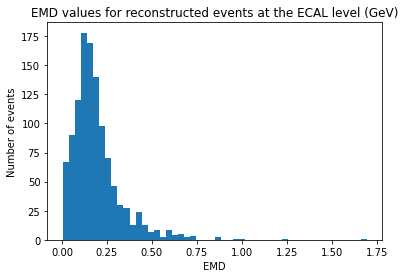

In [ ]:
import matplotlib.pyplot as plt

plt.hist(emd2, bins =50)
plt.title('EMD values for reconstructed events at the ECAL level (GeV)')
plt.xlabel('EMD')
plt.ylabel('Number of events')
plt.show()

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

In [ ]:
def EcalChan(realData,ind):
  ecals=((realData[ind][:,3] == 5.5).nonzero()).tolist()
  ecals2=[]
  for cale in ecals:
    ecals2.append(cale[0])
  return ecals2 

In [ ]:
def hcalChan(realData,ind):
  hcals=((realData[ind][:,3] == 8.5).nonzero()).tolist()
  hcals2=[]
  for cal in hcals:
    hcals2.append(cal[0])
  return hcals2 

**Tracker**

In [ ]:
%matplotlib inline
#xmin, xmax = min(lis4[:,0]), max(lis4[:,0])
#ymin, ymax = min(lis4[:,1]), max(lis4[:,1])
for re in range(15):
  hcals2=hcalChan(whole4,re)
  ecals2=EcalChan(whole4,re)
  if len(hcals2)>4:
    r12=r14[re][:ecals2[0],:].cpu().clone()
    xmin,xmax=0,125
    ymin,ymax=0,125
    binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
    weights=r12[:1000,2]/50
    plt.figure(figsize=(7,6))
    sc = plt.scatter(r12[:1000,0],r12[:1000,1],c=weights,cmap='viridis', norm=LogNorm(),alpha=0.9)

    plt.clim(0.01,10)  # identical to caxis([-4,4]) in MATLAB
    plt.colorbar(sc)
    check=np.arange(0,140,10)
    plt.xticks(check)
    plt.yticks(check)
    plt.grid()
    plt.savefig('./tracker_recs_feb_scalecol/rec'+str(re)+'.png')

In [ ]:
%matplotlib inline
for re in range(15):
  hcals2=hcalChan(whole4,re)
  ecals2=EcalChan(whole4,re)
  if len(hcals2)>4:
    r12=whole4[re][:ecals2[0],:].cpu().numpy().copy()
    xmin,xmax=0,125
    ymin,ymax=0,125
    binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
    weights=r12[:1000,2]/50
    plt.figure(figsize=(7,6))
    sc = plt.scatter(r12[:1000,0],r12[:1000,1],c=weights,cmap='viridis', norm=LogNorm(),alpha=0.9)
    plt.clim(0.01,10)  # identical to caxis([-4,4]) in MATLAB
    plt.colorbar(sc)
    check=np.arange(0,140,10)
    plt.xticks(check)
    plt.yticks(check)
    plt.grid()
    plt.savefig('./tracker_real_feb_scalecol/real'+str(re)+'.png')

**ECAL**

In [ ]:
whole4.shape

torch.Size([64, 1000, 4])

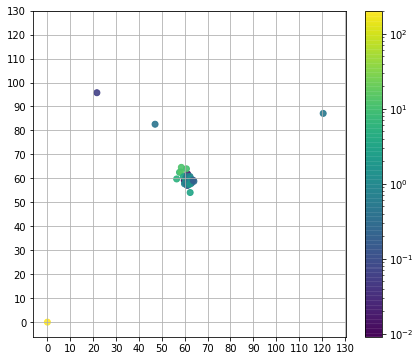

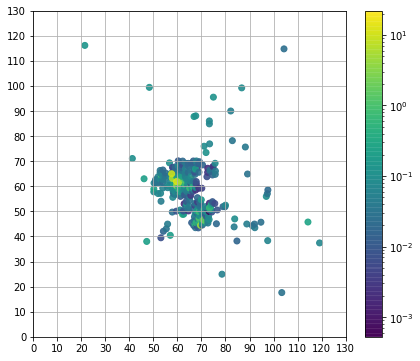

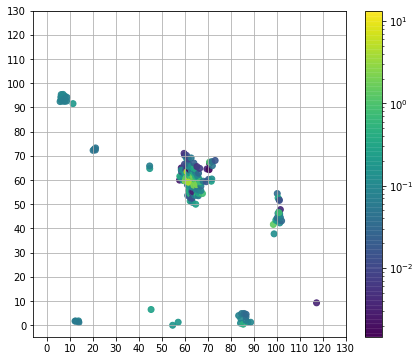

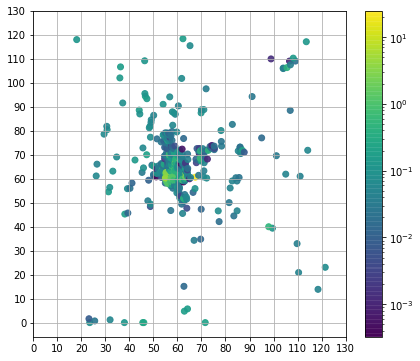

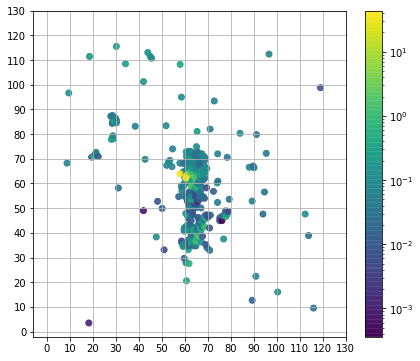

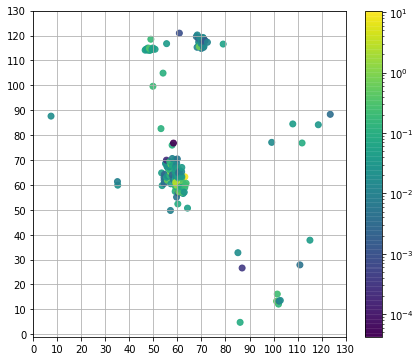

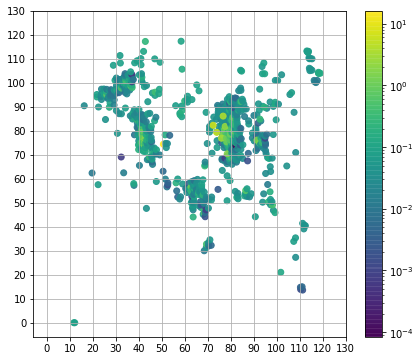

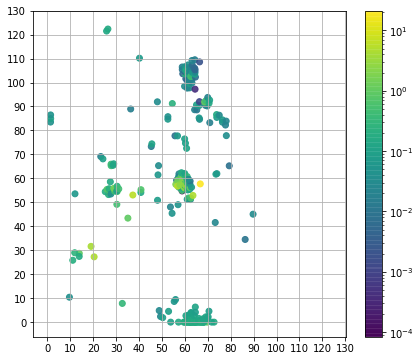

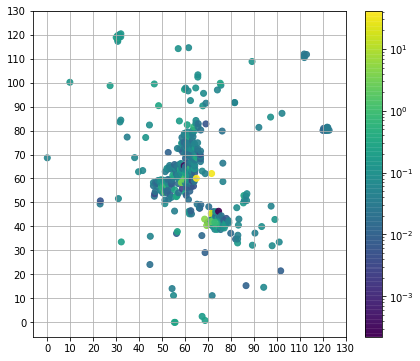

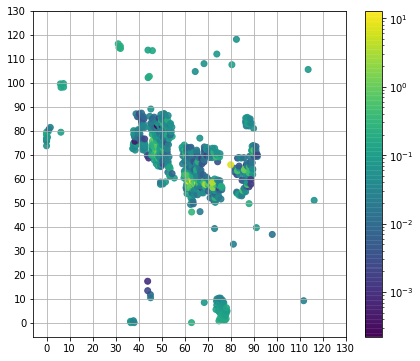

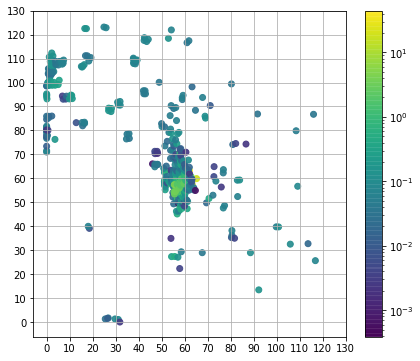

In [ ]:
%matplotlib inline
#xmin, xmax = min(lis4[:,0]), max(lis4[:,0])
#ymin, ymax = min(lis4[:,1]), max(lis4[:,1])
for re in range(15):
  hcals2=hcalChan(whole4,re)
  ecals2=EcalChan(whole4,re)
  if len(hcals2)>4:
    r12=r14[re][ecals2[0]:hcals2[0],:].cpu().clone()
    xmin,xmax=0,125
    ymin,ymax=0,125
    binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
    weights=r12[:1000,2]*2/50
    plt.figure(figsize=(7,6))
    sc = plt.scatter(r12[:1000,0],r12[:1000,1],c=weights,cmap='viridis',norm=LogNorm(), alpha=0.9)
    #plt.clim(0.001,100)  # identical to caxis([-4,4]) in MATLAB
    plt.colorbar(sc)
    check=np.arange(0,140,10)
    plt.xticks(check)
    plt.yticks(check)
    plt.grid()
    #plt.savefig('./ecal_recs_feb_scalecol/rec'+str(re)+'.png')

In [ ]:
weights

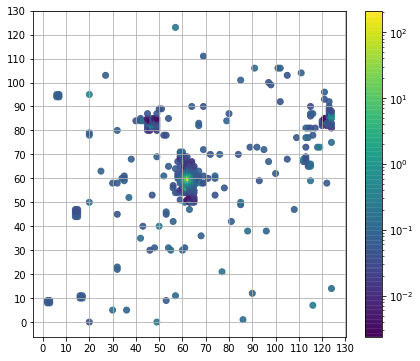

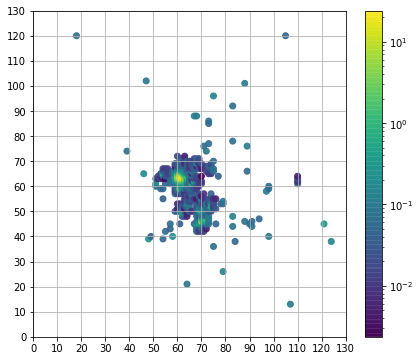

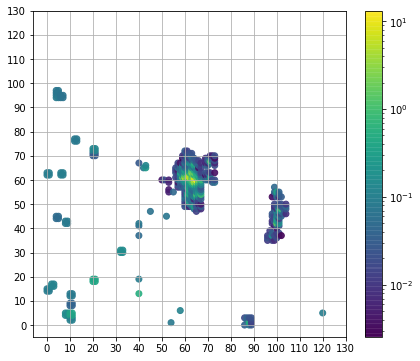

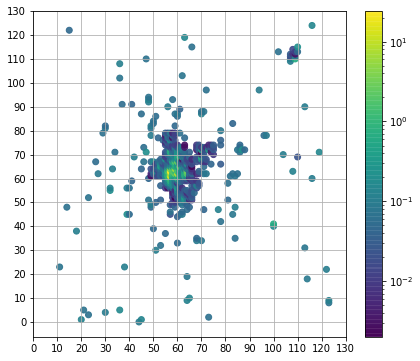

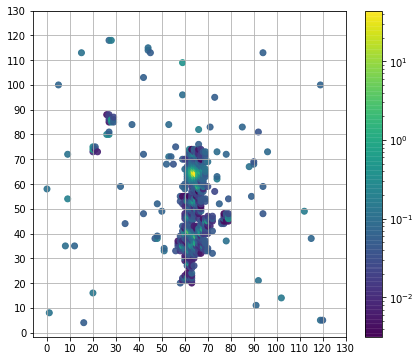

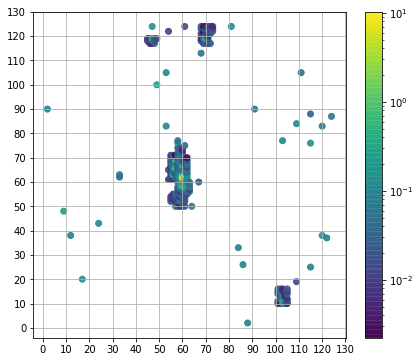

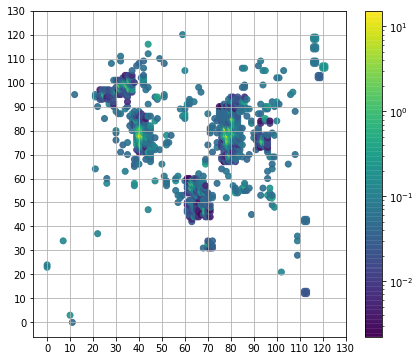

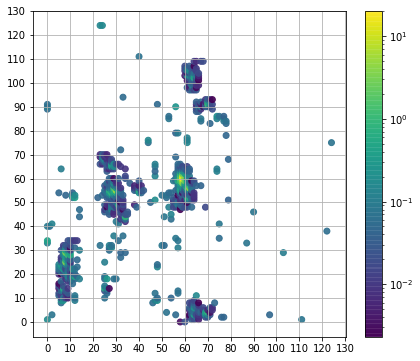

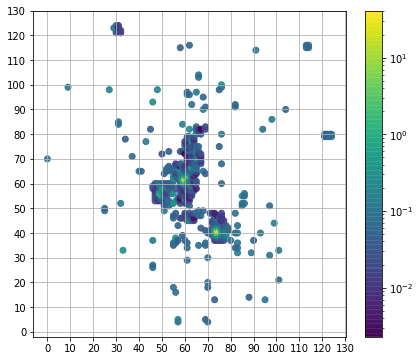

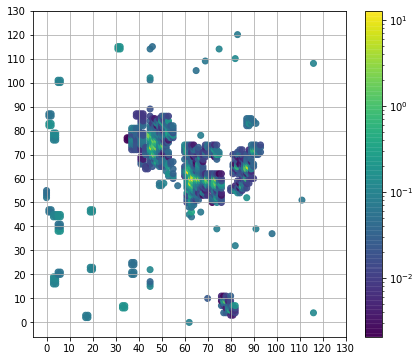

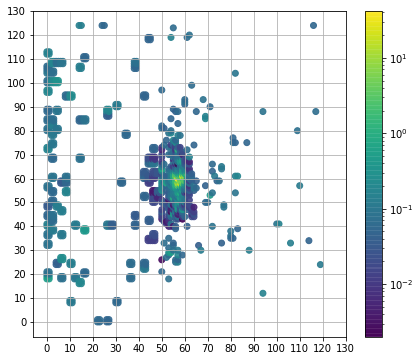

In [ ]:
%matplotlib inline
for re in range(15):
  hcals2=hcalChan(whole4,re)
  ecals2=EcalChan(whole4,re)
  if len(hcals2)>4:
    r12=whole4[re][ecals2[0]:hcals2[0],:].cpu().numpy().copy()
    xmin,xmax=0,125
    ymin,ymax=0,125
    binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
    weights=r12[:1000,2]*2/50
    plt.figure(figsize=(7,6))
    sc = plt.scatter(r12[:1000,0],r12[:1000,1],c=weights,cmap='viridis', norm=LogNorm(), alpha=0.9)
    #plt.clim(0.001,500)  # identical to caxis([-4,4]) in MATLAB
    plt.colorbar(sc)
    check=np.arange(0,140,10)
    plt.xticks(check)
    plt.yticks(check)
    plt.grid()
    #plt.savefig('./ecal_real_feb_scalecol/real'+str(re)+'.png')

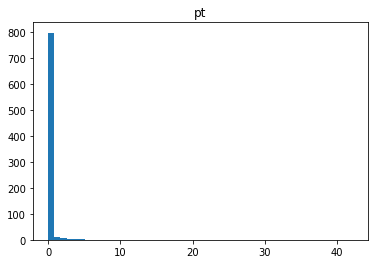

In [ ]:
import matplotlib.pyplot as plt

plt.hist(weights, bins =50)
plt.title('pt')
plt.show()

In [ ]:
weights.max()

8.990253511111112

In [ ]:
whole4.shape

**HCAL**

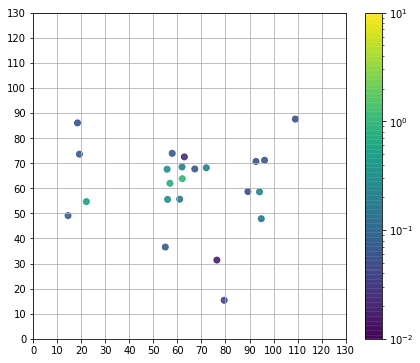

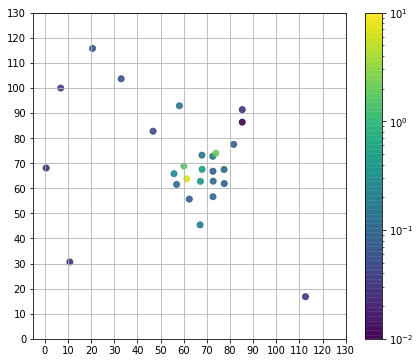

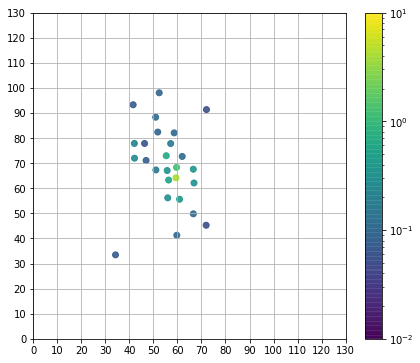

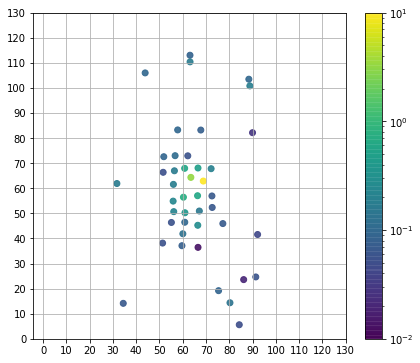

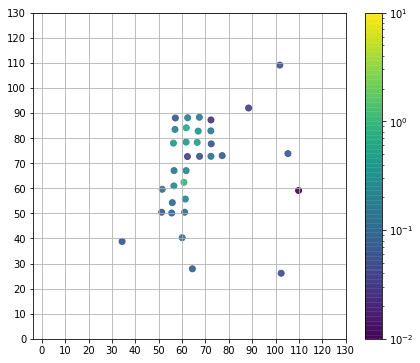

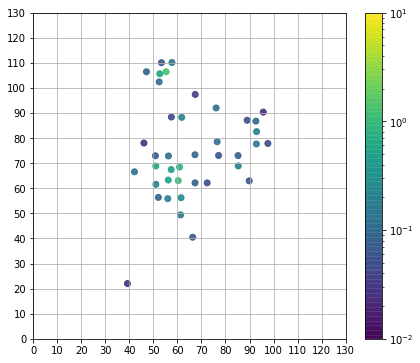

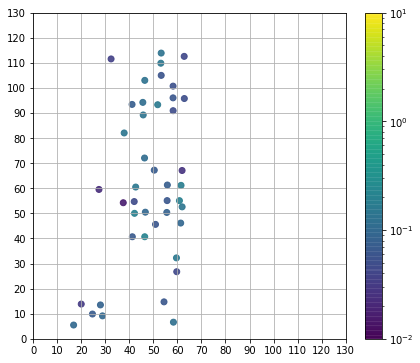

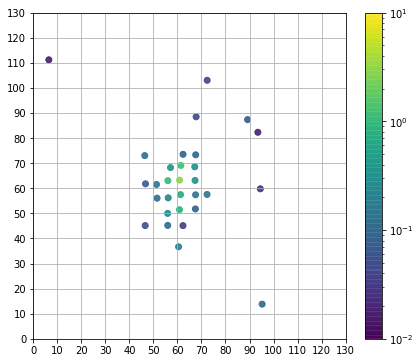

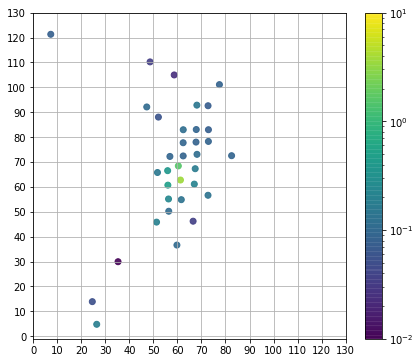

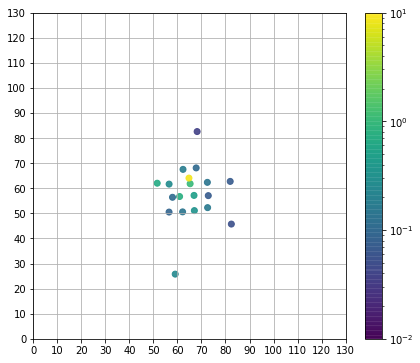

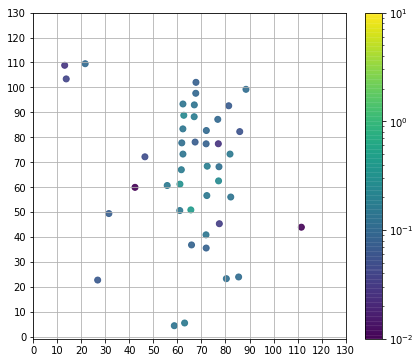

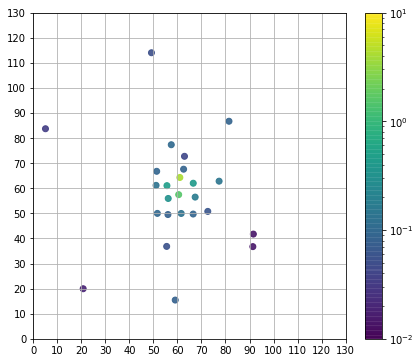

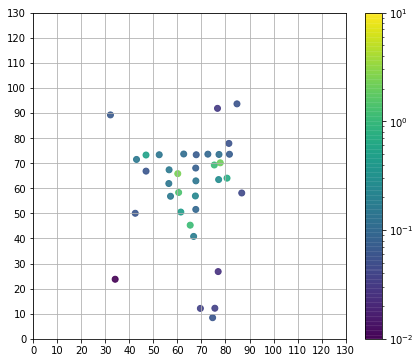

In [ ]:
%matplotlib inline
#xmin, xmax = min(lis4[:,0]), max(lis4[:,0])
#ymin, ymax = min(lis4[:,1]), max(lis4[:,1])
for re in range(15):
  hcals2=hcalChan(whole4,re)
  if len(hcals2)>4:
    r12=r14[re][hcals2,:].cpu().clone()
    xmin,xmax=0,125
    ymin,ymax=0,125
    binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
    weights=r12[:1000,2]/50
    plt.figure(figsize=(7,6))
    sc = plt.scatter(r12[:1000,0],r12[:1000,1],c=weights,cmap='viridis', norm=LogNorm(),alpha=0.9)
    plt.clim(0.01,10)  # identical to caxis([-4,4]) in MATLAB
    plt.colorbar(sc)
    check=np.arange(0,140,10)
    plt.xticks(check)
    plt.yticks(check)
    plt.grid()
    plt.savefig('./hcal_recs_feb_scalecol/rec'+str(re)+'.png')

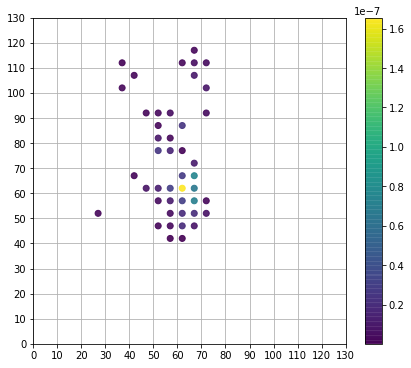

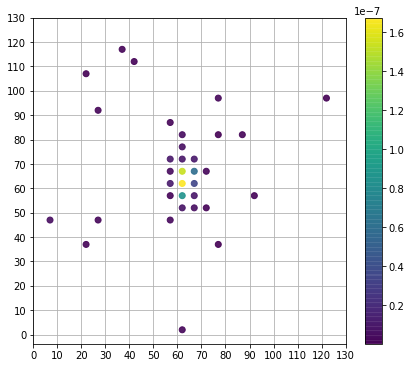

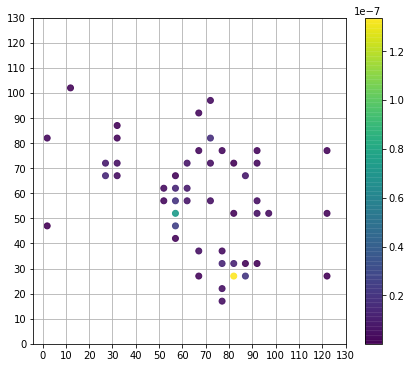

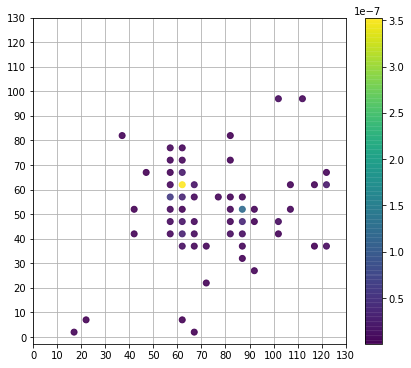

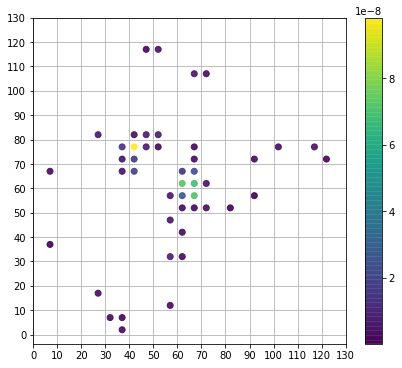

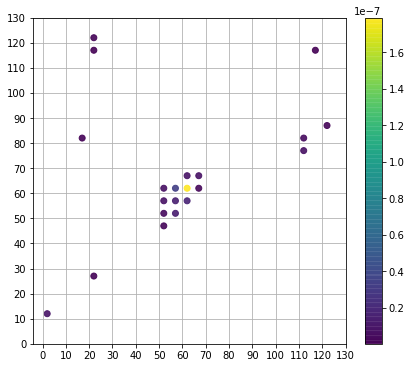

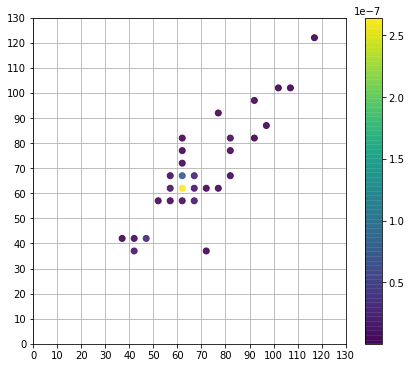

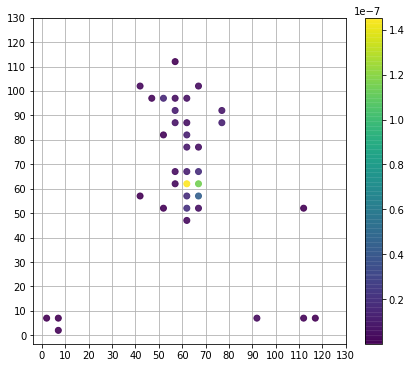

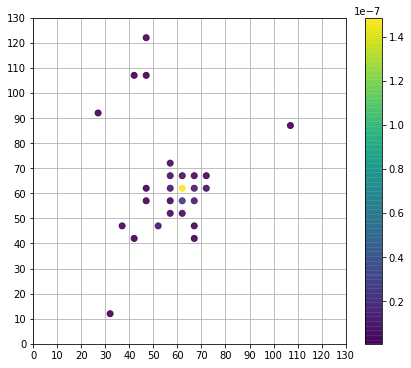

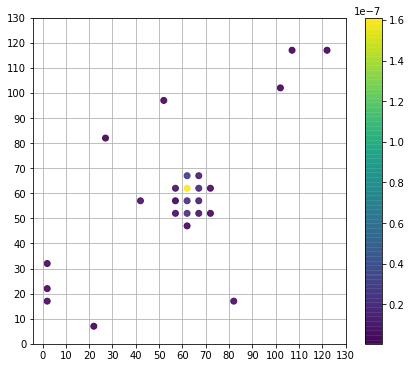

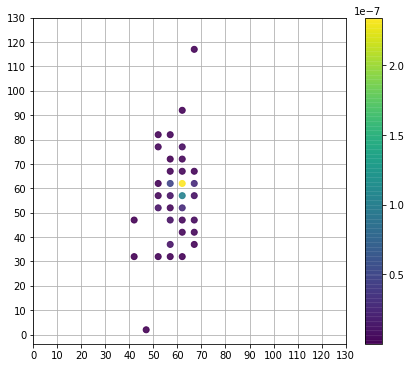

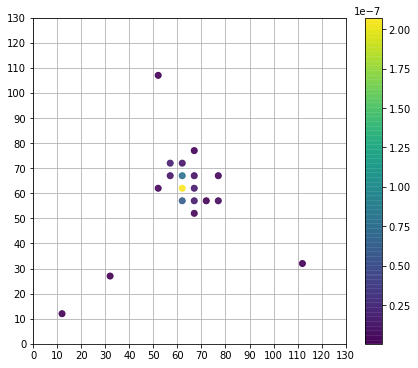

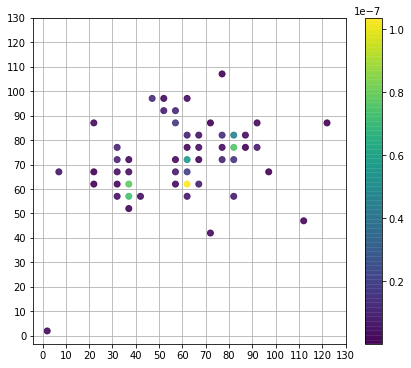

In [ ]:
%matplotlib inline
for re in range(15):
  hcals2=hcalChan(whole4,re)
  if len(hcals2)>4:
    r12=whole4[re][hcals2,:].cpu().numpy().copy()
    xmin,xmax=0,125
    ymin,ymax=0,125
    binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
    weights=r12[:1000,2]/900000000
    plt.figure(figsize=(7,6))
    sc = plt.scatter(r12[:1000,0],r12[:1000,1],c=weights,cmap='viridis',alpha=0.9)
    #plt.clim(0.01,10)  # identical to caxis([-4,4]) in MATLAB
    plt.colorbar(sc)
    check=np.arange(0,140,10)
    plt.xticks(check)
    plt.yticks(check)
    plt.grid()
    #plt.savefig('./hcal_real_feb_scalecol/rec'+str(re)+'.png')

In [ ]:
%matplotlib inline
for re in range(15):
  #xmin, xmax = min(lis4[:,0]), max(lis4[:,0])
  #ymin, ymax = min(lis4[:,1]), max(lis4[:,1])
  r12=r14[re].cpu().clone()
  xmin,xmax=0,125
  ymin,ymax=0,125
  binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
  weights=r12[:1000,2]/50
  plt.figure(figsize=(7,6))
  sc = plt.scatter(r12[:1000,0],r12[:1000,1],c=weights,cmap='viridis', norm=LogNorm(),alpha=0.9)
  plt.colorbar(sc)
  check=np.arange(0,140,10)
  plt.xticks(check)
  plt.yticks(check)
  plt.grid()
  plt.savefig('./Rec2/rec'+str(re)+'.png')

In [ ]:
for rea in range(15):
  r12=whole4[rea].cpu().numpy().copy()
  xmin,xmax=0,125
  ymin,ymax=0,125
  binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
  weights=r12[:1000,2]/50
  plt.figure(figsize=(7,6))
  sc = plt.scatter(r12[:1000,0],r12[:1000,1],c=weights,cmap='viridis', norm=LogNorm(),alpha=0.9)
  plt.colorbar(sc)
  check=np.arange(0,140,10)
  plt.xticks(check)
  plt.yticks(check)
  plt.grid()
  plt.savefig('./Reals2/real'+str(rea)+'.png')

In [ ]:
  hcals2=hcalChan(whole4,0)

In [ ]:
r14[6]